In [2]:
import os
import re
import datetime
from mordred import Calculator, descriptors
from rdkit import Chem
import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
import sys
import torch
from rdkit.Chem import AllChem


feature_list =['Reagent1 (ul)', 'Reagent2 (ul)', 'Reagent3 (ul)', 'Reagent4 (ul)', 'lab_code']
methods = ['ABC','PSO','Random']
GT_data = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/0_Create_Ground_Truth_Model/datasets/combined_compiledData.csv')

ABC = []
PSO = []
Random = []


for method in methods:
    if method == 'ABC':
        for i in range(10):
            filename = f"/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/3_Make_New_Data_Predictor/{method}/round{i+1}/cycle5.csv"
            df = pd.read_csv(filename)
            ABC.append(df[10:])
    if method =='PSO':
        for i in range(10):
            filename = f"/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/3_Make_New_Data_Predictor/{method}/round{i+1}/cycle5.csv"
            df = pd.read_csv(filename)
            PSO.append(df[10:])

    if method =='Random':
        for i in range(10):
            filename = f"/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/3_Make_New_Data_Predictor/{method}/round{i+1}/cycle5.csv"
            df = pd.read_csv(filename)
            Random.append(df[10:])



ABC = pd.concat(ABC, ignore_index=True)
PSO = pd.concat(PSO, ignore_index=True)
Random = pd.concat(Random, ignore_index=True)


ABCfingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in ABC['SMILES']]
PSOfingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in PSO['SMILES']]
Randomfingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in Random['SMILES']]
GTfingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in GT_data['SMILES']]


ABC_fp_array = np.array([list(fp) for fp in ABCfingerprints])
PSO_fp_array = np.array([list(fp) for fp in PSOfingerprints])
Random_fp_array = np.array([list(fp) for fp in Randomfingerprints])
GT_fp_array = np.array([list(fp) for fp in GTfingerprints])

fp_array = np.concatenate((ABC_fp_array, PSO_fp_array,Random_fp_array,GT_data), axis=0)

crystal_size = (pd.concat([ABC, PSO, Random, GT_data], ignore_index=True))[['crystal_size']]


print(crystal_size)

ABC = ABC[feature_list]
PSO = PSO[feature_list]
Random = Random[feature_list]
GT_data = GT_data[feature_list]


      crystal_size
0         1.906324
1         1.671430
2         1.341401
3         1.118565
4         1.056210
...            ...
1495      1.837591
1496      1.543171
1497      1.517777
1498      1.425842
1499      1.398253

[1500 rows x 1 columns]


/tmp/ipykernel_44375/1731003631.py:1: DeprecationWarning: Accessing jsonschema.draft3_format_checker is deprecated and will be removed in a future release. Instead, use the FORMAT_CHECKER attribute on the corresponding Validator.
  from jsonschema import draft3_format_checker
/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_44375/1731003631.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

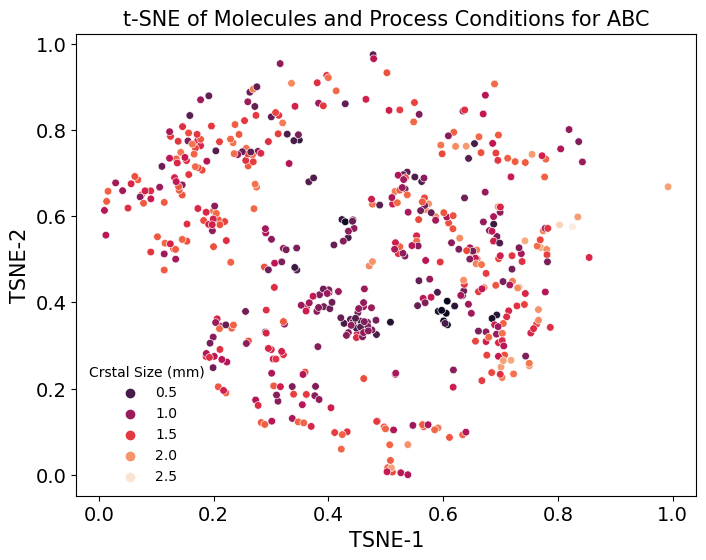

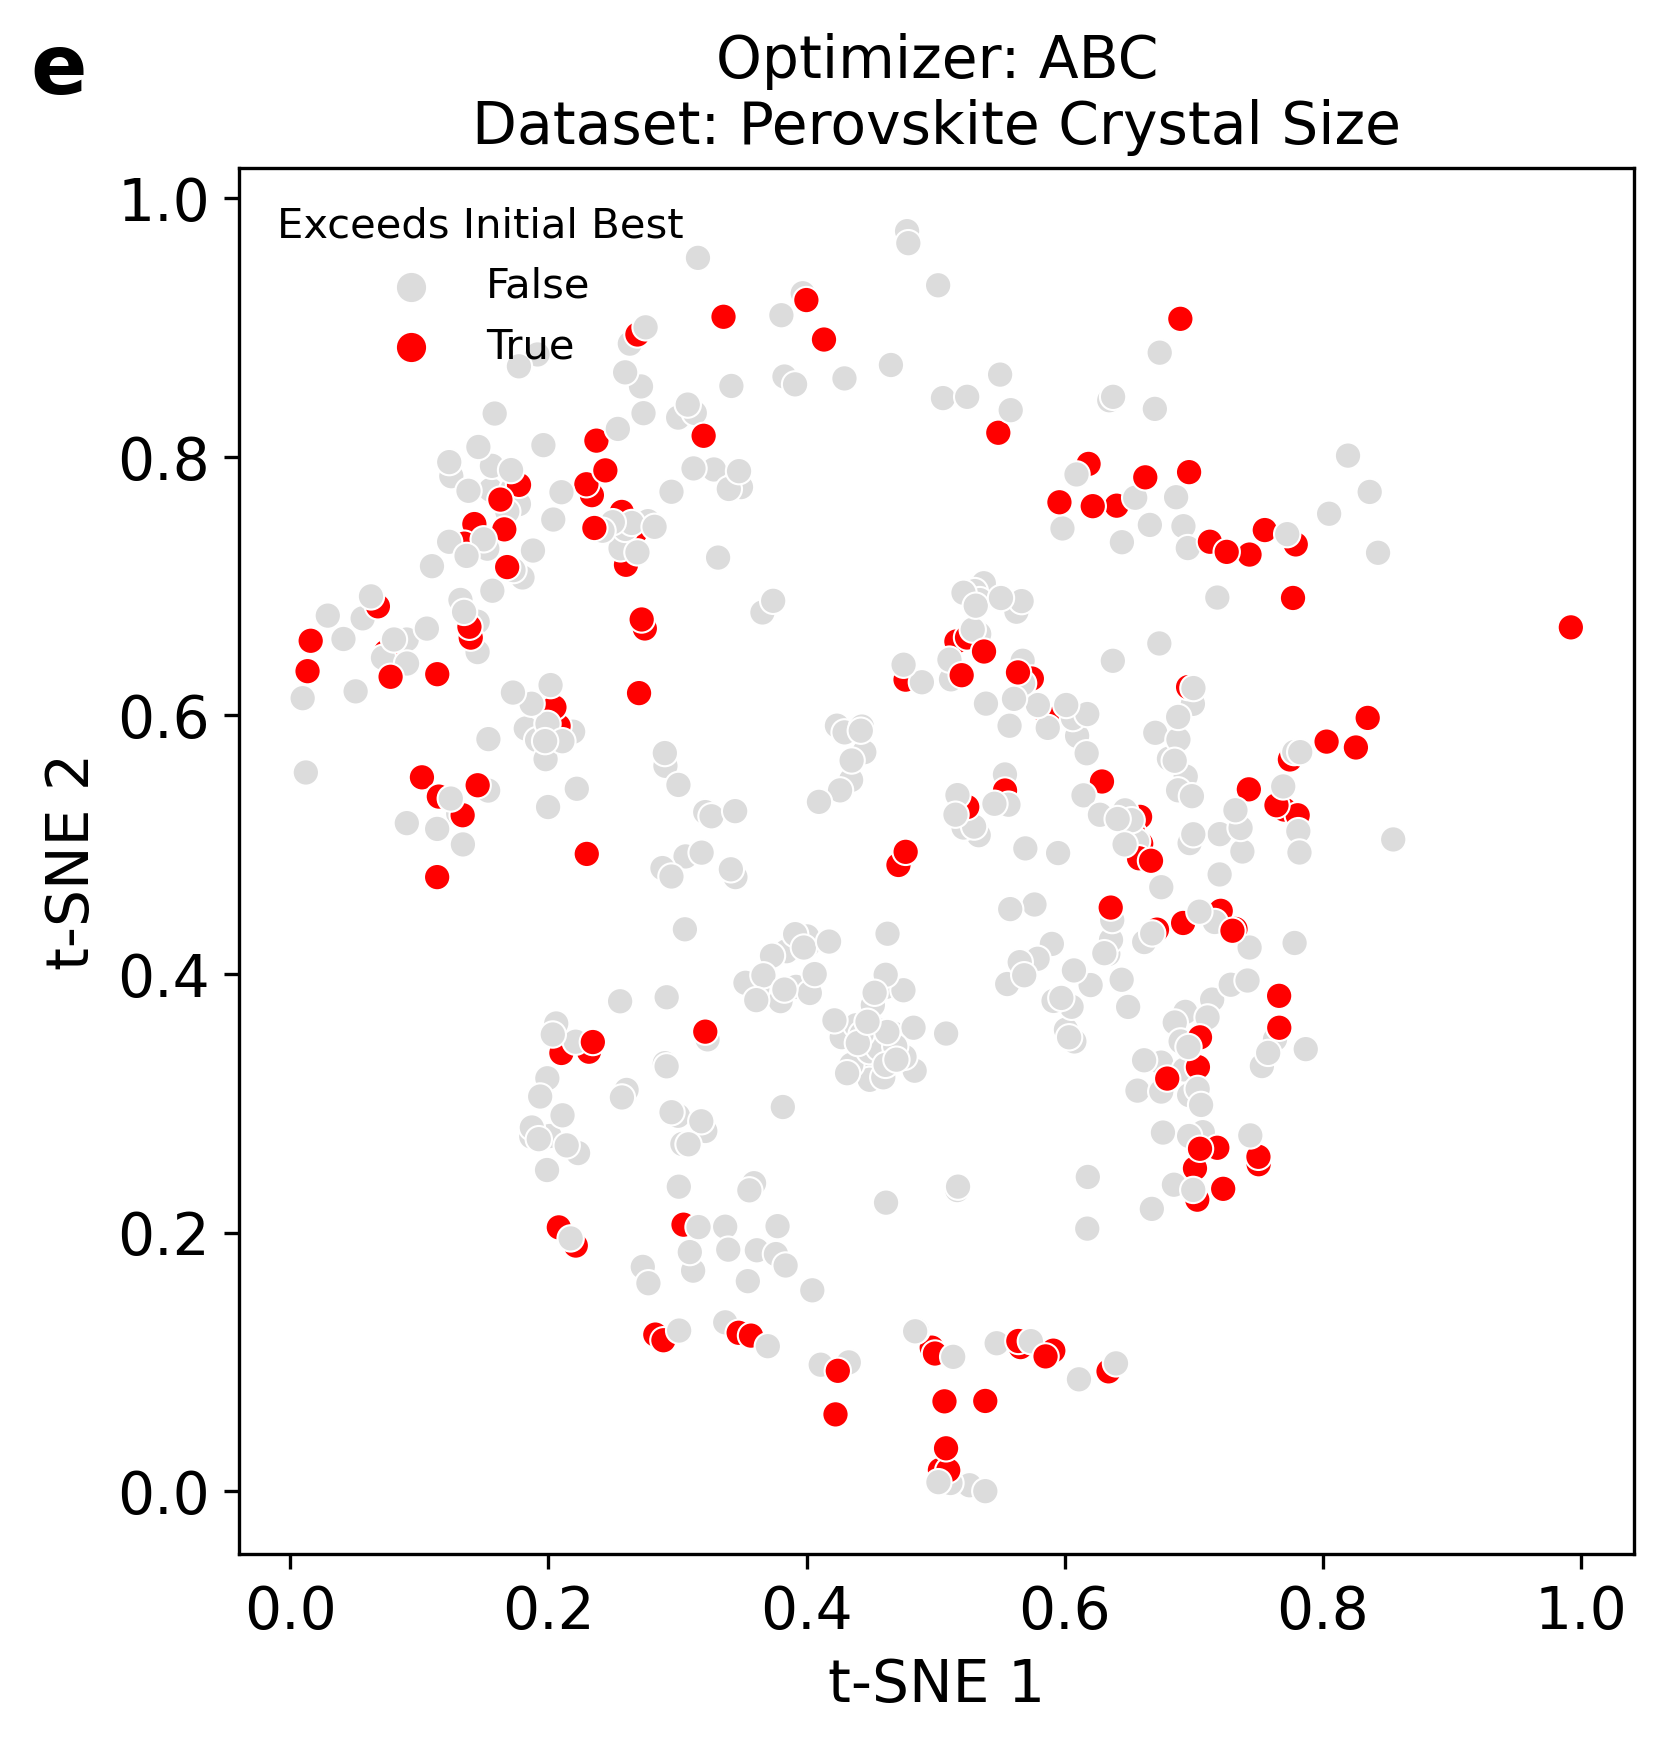

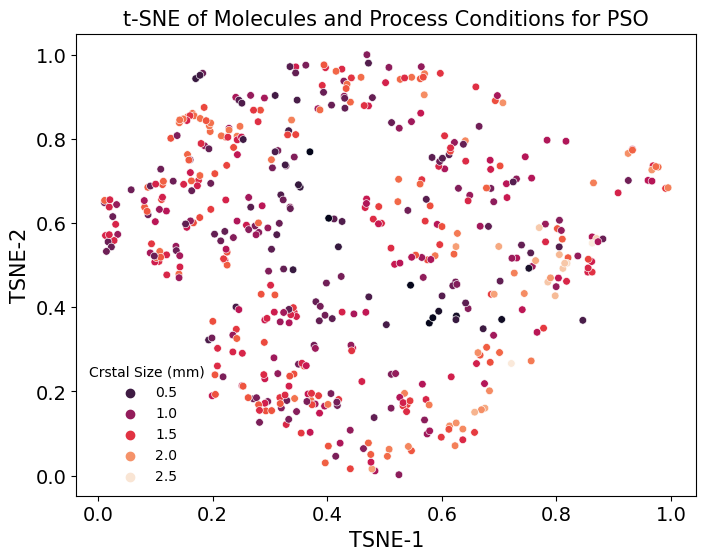

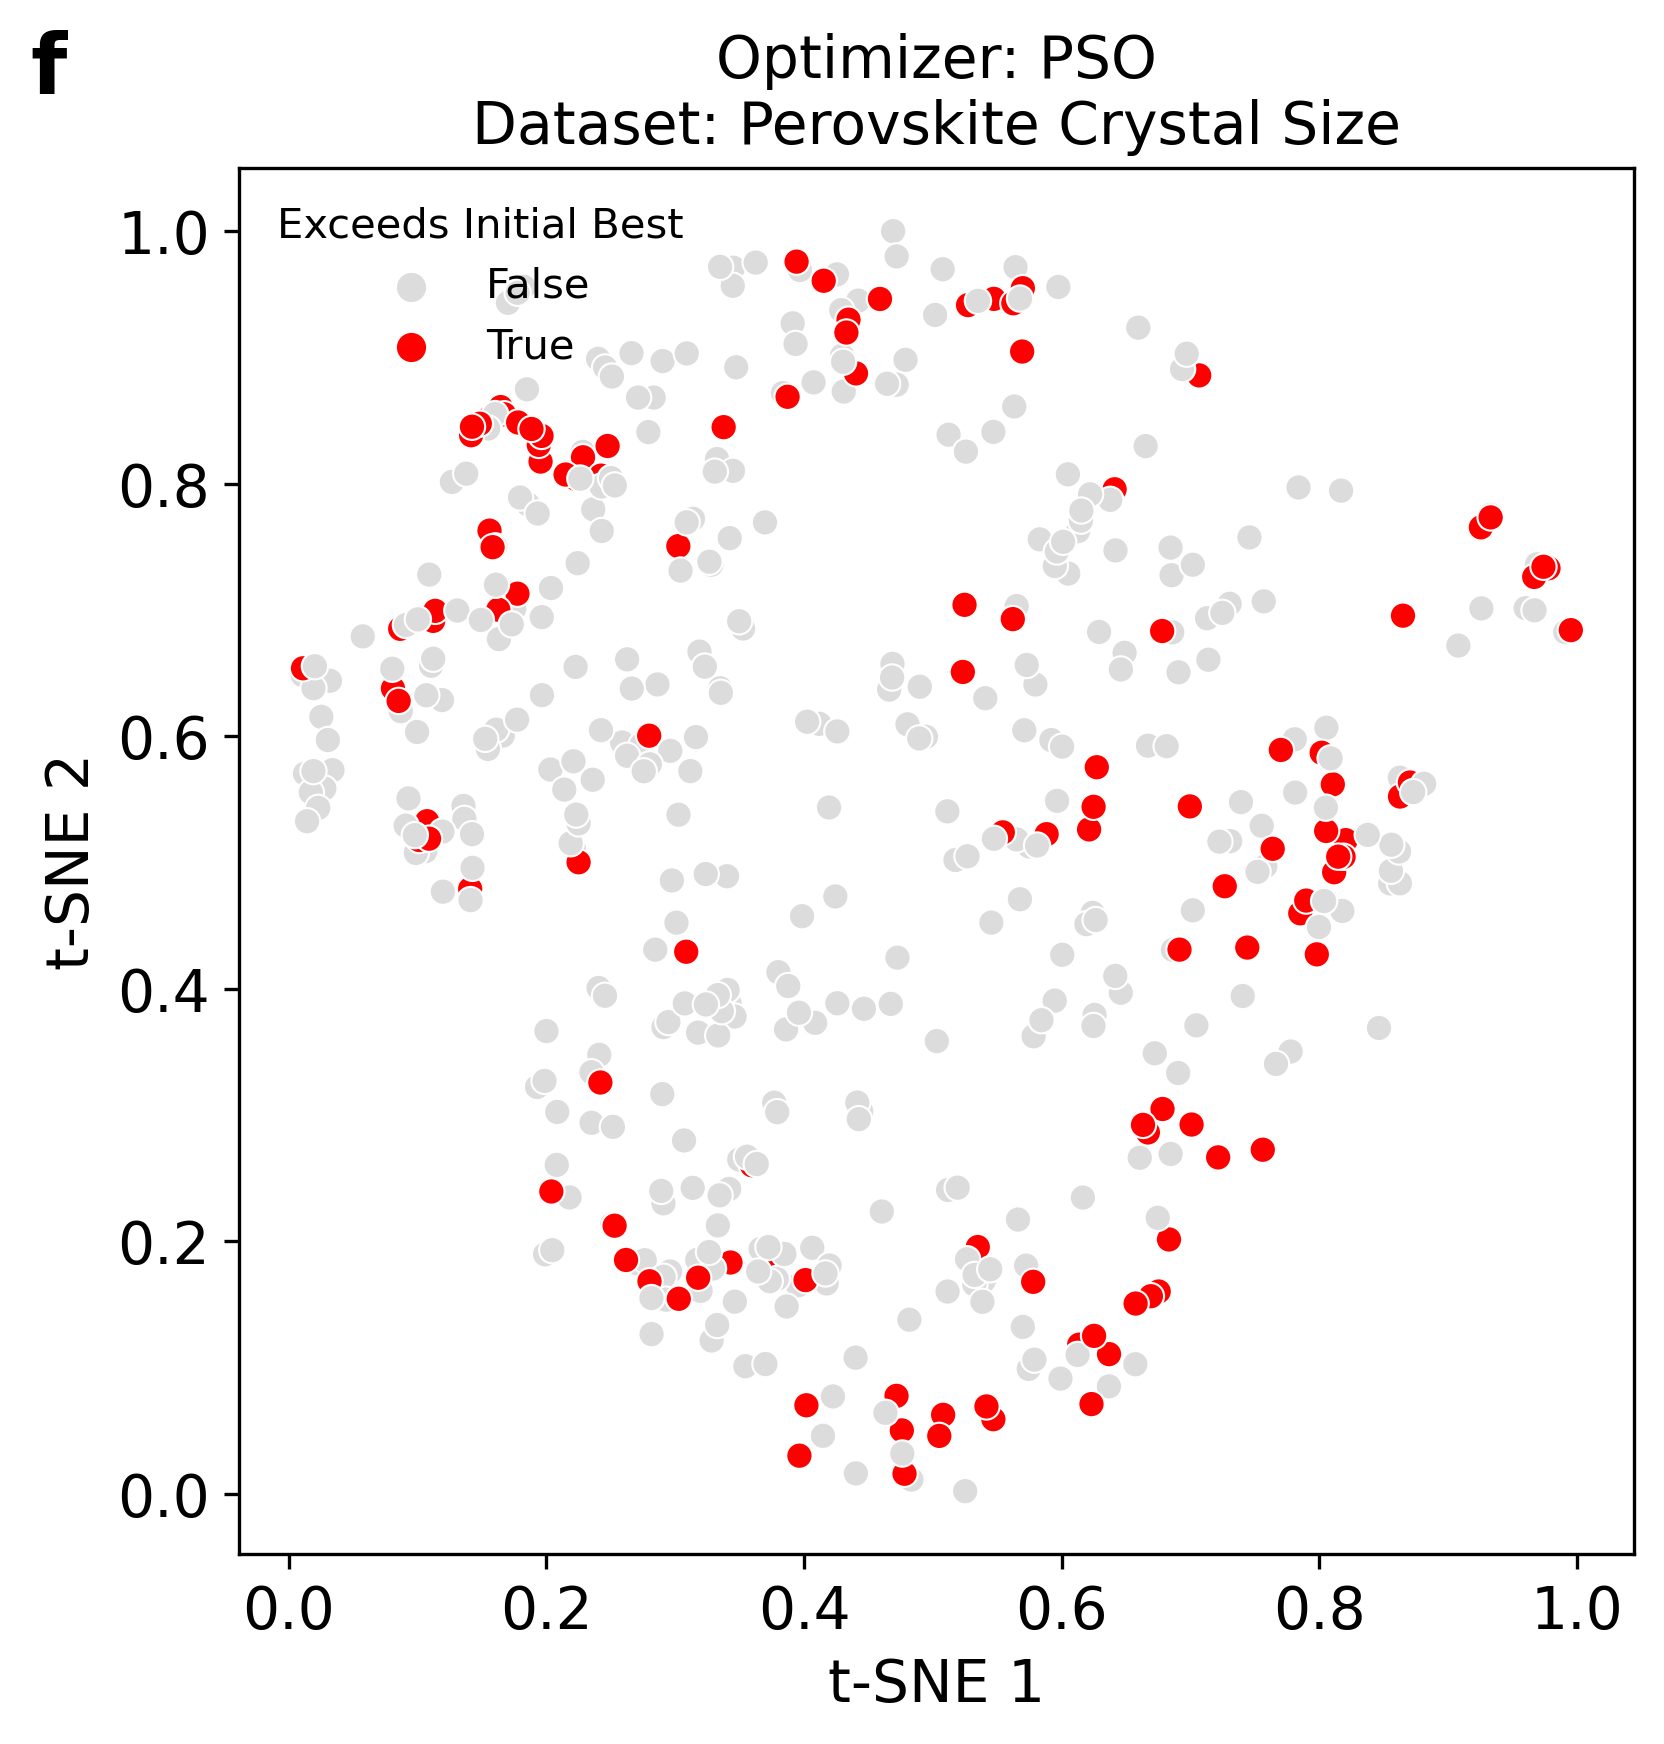

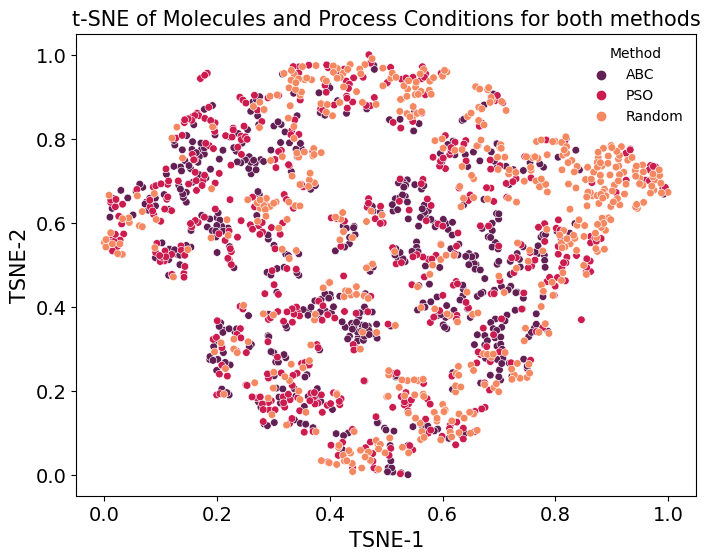

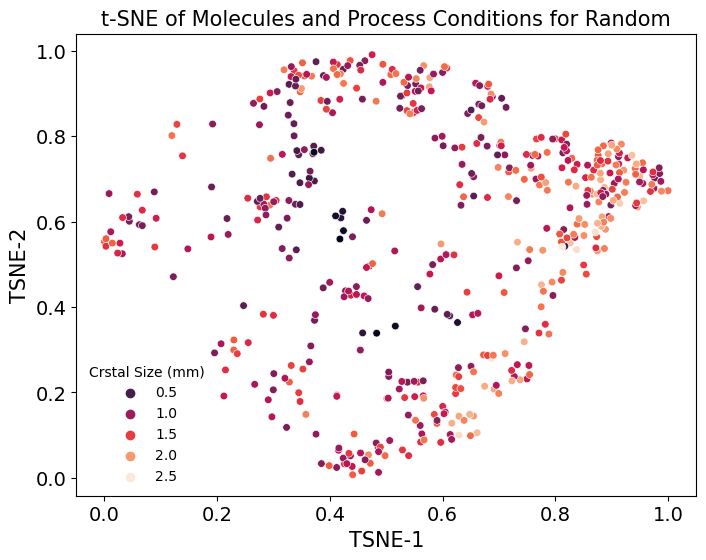

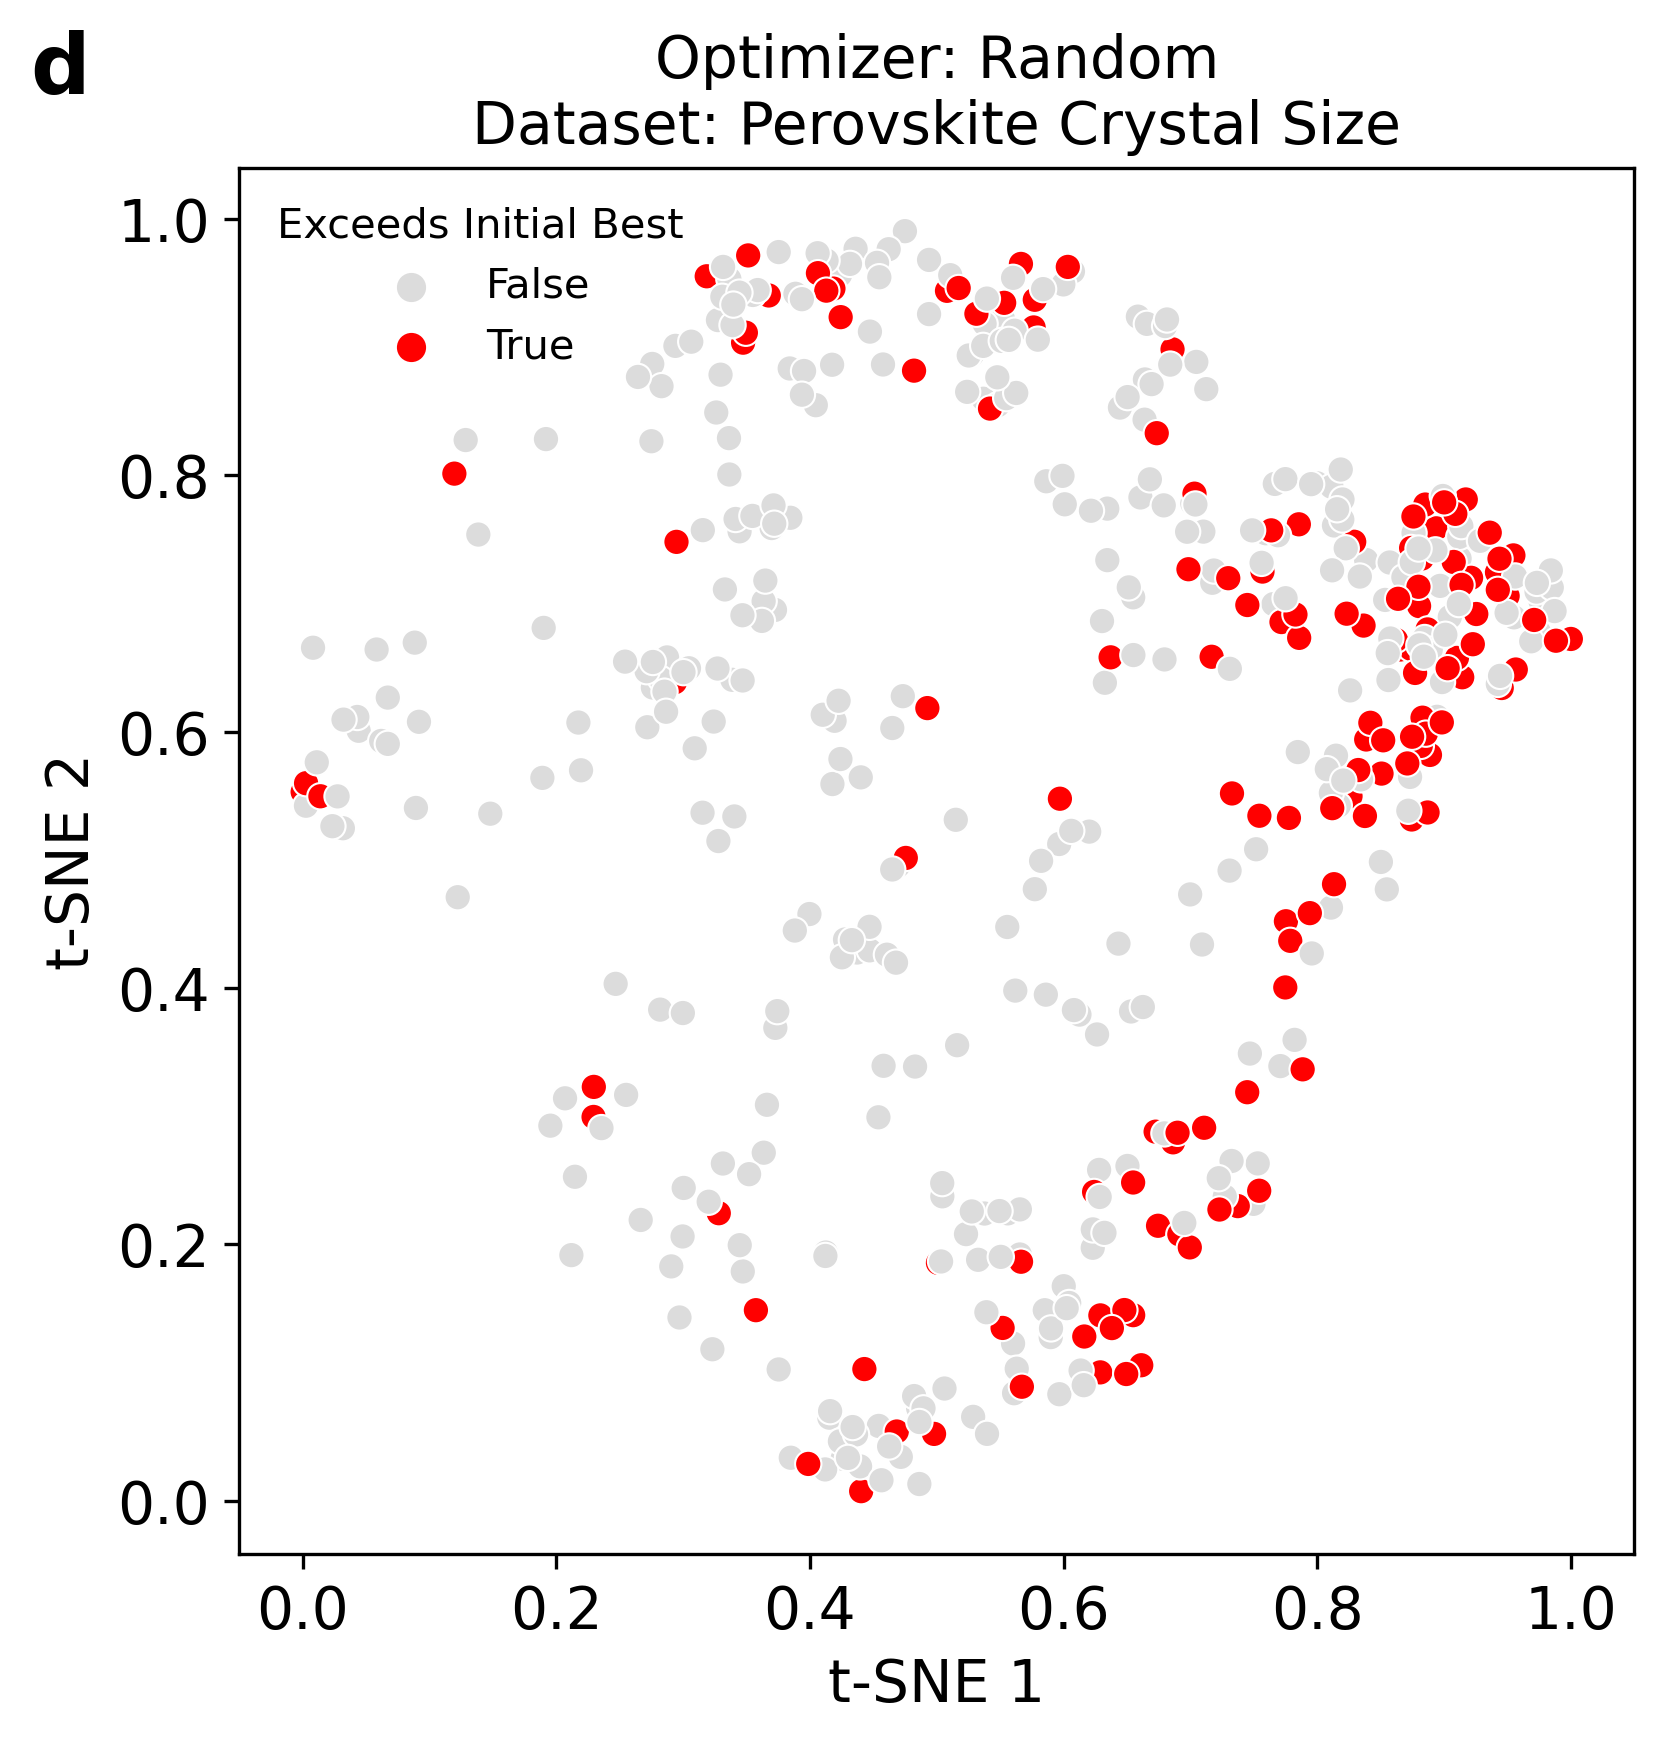

In [3]:
from jsonschema import draft3_format_checker
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from mordred import Calculator, descriptors
from rdkit import Chem
from sklearn.preprocessing import MinMaxScaler

#first combine without latent
c_df = pd.concat([ABC, PSO,Random], ignore_index=True)
#c_df = data2

c_df = c_df.values
c_df = np.concatenate((c_df, fp_array), axis=1)
#c_df = latent

# Apply t-SNE
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(c_df)

# Normalize the t-SNE values
scaler = MinMaxScaler()
tsne_results_normalized = scaler.fit_transform(tsne_results)


# Add a column to indicate the dataset
ABC['dataset'] = 'ABC'
PSO['dataset'] = 'PSO'
Random['dataset'] = 'Random'

ABC['crystal_size'] = crystal_size.iloc[:500].values
PSO['crystal_size'] = crystal_size.iloc[500:1000].values
Random['crystal_size'] = crystal_size.iloc[1000:1500].values

# Combine the datasets
combined_df = pd.concat([ABC, PSO, Random], ignore_index=True)
#combined_df = data2

# Add normalized t-SNE results to the DataFrame
combined_df['TSNE-1'] = tsne_results_normalized[:, 0]
combined_df['TSNE-2'] = tsne_results_normalized[:, 1]

df1 = combined_df.iloc[:500]
df2 = combined_df.iloc[500:1000]
df3 = combined_df.iloc[1000:1500]

threshold = 1.66
threshold2 = 1.76
threshold3 = 1.86
threshold4 = 1.96

df1['group'] = df1['crystal_size'] > threshold  
df2['group'] = df2['crystal_size'] > threshold  
df3['group'] = df3['crystal_size'] > threshold 

df1['group2'] = df1['crystal_size'] > threshold2  
df2['group2'] = df2['crystal_size'] > threshold2  
df3['group2'] = df3['crystal_size'] > threshold2  

df1['group3'] = df1['crystal_size'] > threshold3  
df2['group3'] = df2['crystal_size'] > threshold3  
df3['group3'] = df3['crystal_size'] > threshold3  

df1['group4'] = df1['crystal_size'] > threshold4  
df2['group4'] = df2['crystal_size'] > threshold4  
df3['group4'] = df3['crystal_size'] > threshold4  

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TSNE-1', y='TSNE-2', hue = 'crystal_size', palette='rocket',data=df1, s=30)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('t-SNE of Molecules and Process Conditions for ABC', fontsize=15)
plt.xlabel('TSNE-1', fontsize = 15)
plt.ylabel('TSNE-2', fontsize = 15)
plt.legend(frameon = False, title='Crstal Size (mm)')
plt.show()

fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
sns.scatterplot(x='TSNE-1', y='TSNE-2', hue = 'group', data=df1, palette={True: 'red', False: '#DCDCDC'},s=40)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

ax.text(-0.15, 1.1, 'e',
        transform=ax.transAxes,
        fontsize=20, fontweight='bold',
        va='top', ha='left')


plt.title('Optimizer: ABC\nDataset: Perovskite Crystal Size', fontsize=14)
plt.xlabel('t-SNE 1', fontsize = 14)
plt.ylabel('t-SNE 2', fontsize = 14)
plt.legend(frameon=False, title='Exceeds Initial Best', loc = 'upper left')
plt.savefig('/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/4_Final_Anslysis_Like_EDBO/ABCPvk.jpeg')
plt.show()

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TSNE-1', y='TSNE-2', hue = 'crystal_size', data=df2, palette='rocket',s=30)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('t-SNE of Molecules and Process Conditions for PSO', fontsize=15)
plt.xlabel('TSNE-1', fontsize = 15)
plt.ylabel('TSNE-2', fontsize = 15)
plt.legend(frameon=False, title='Crstal Size (mm)')
plt.show()

# Plot the t-SNE results
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
sns.scatterplot(x='TSNE-1', y='TSNE-2', hue = 'group', data=df2, palette={True: 'red', False: '#DCDCDC'},s=40)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

ax.text(-0.15, 1.1, 'f',
        transform=ax.transAxes,
        fontsize=20, fontweight='bold',
        va='top', ha='left')


plt.title('Optimizer: PSO\nDataset: Perovskite Crystal Size', fontsize=14)
plt.xlabel('t-SNE 1', fontsize = 14)
plt.ylabel('t-SNE 2', fontsize = 14)
plt.legend(frameon=False, title='Exceeds Initial Best', loc = 'upper left')
plt.savefig('/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/4_Final_Anslysis_Like_EDBO/PSOPvk.jpeg')
plt.show()

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TSNE-1', y='TSNE-2', hue = 'dataset', data=combined_df, palette='rocket',s=30)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('t-SNE of Molecules and Process Conditions for both methods', fontsize=15)
plt.xlabel('TSNE-1', fontsize = 15)
plt.ylabel('TSNE-2', fontsize = 15)
plt.legend(frameon=False, title='Method')
plt.show()

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TSNE-1', y='TSNE-2', hue = 'crystal_size', palette='rocket',data=df3, s=30)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('t-SNE of Molecules and Process Conditions for Random', fontsize=15)
plt.xlabel('TSNE-1', fontsize = 15)
plt.ylabel('TSNE-2', fontsize = 15)
plt.legend(frameon = False, title='Crstal Size (mm)')
plt.show()

# Plot the t-SNE results
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
sns.scatterplot(x='TSNE-1', y='TSNE-2', hue = 'group', data=df3, palette={True: 'red', False: '#DCDCDC'},s=40)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

ax.text(-0.15, 1.1, 'd',
        transform=ax.transAxes,
        fontsize=20, fontweight='bold',
        va='top', ha='left')


plt.title('Optimizer: Random\nDataset: Perovskite Crystal Size', fontsize=14)
plt.xlabel('t-SNE 1', fontsize = 14)
plt.ylabel('t-SNE 2', fontsize = 14)
plt.legend(frameon=False, title='Exceeds Initial Best', loc = 'upper left')
plt.savefig('/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/4_Final_Anslysis_Like_EDBO/RandomPvk.jpeg')
plt.show()

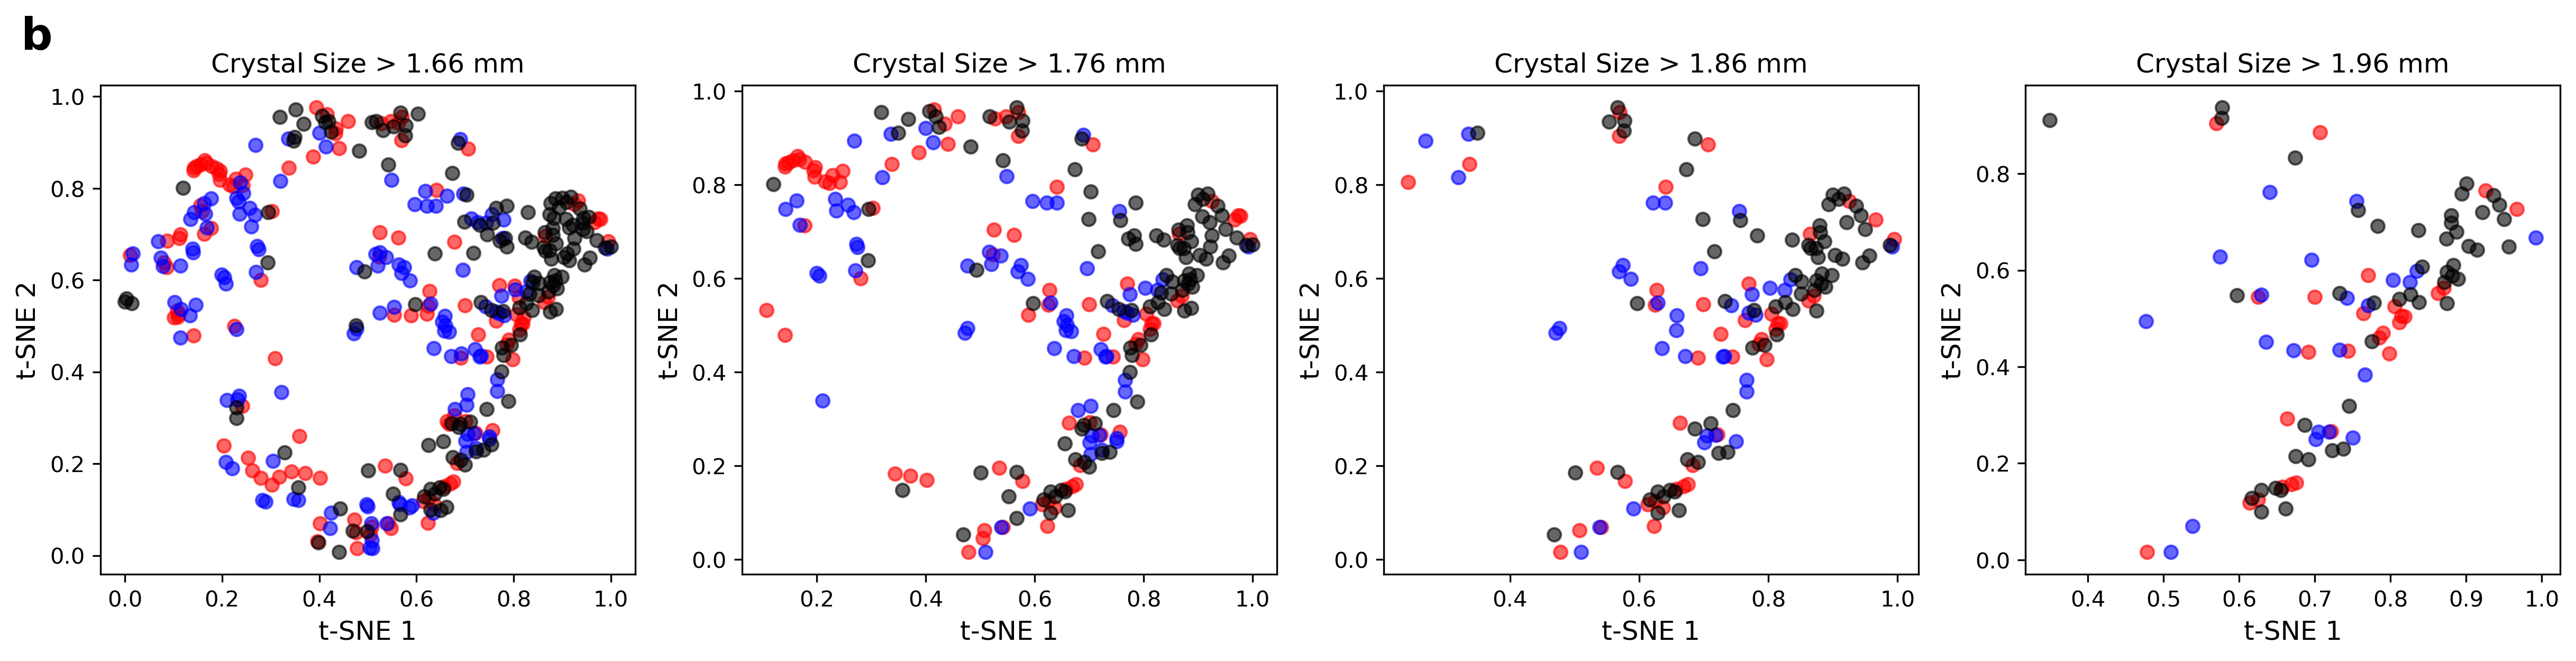

In [4]:
groups = ['group', 'group2','group3','group4']
nums = {'group':0, 'group2':1, 'group3':2, 'group4':3}
names = {'group':'1.66', 'group2':'1.76', 'group3':'1.86', 'group4':'1.96'}

fig, ax = plt.subplots(1, 4, figsize=(20, 4), dpi=300)

for group in groups:
    num = nums[group]
    name = names[group]
    
    ABC_cut = df1[df1[group]][['TSNE-1', 'TSNE-2']]
    PSO_cut = df2[df2[group]][['TSNE-1', 'TSNE-2']]
    random_cut = df3[df3[group]][['TSNE-1', 'TSNE-2']]
    ax[num].set_xlabel('t-SNE 1', fontsize = 12)
    ax[num].set_ylabel('t-SNE 2', fontsize = 12)
    ax[num].scatter(x=PSO_cut['TSNE-1'], y=PSO_cut['TSNE-2'],color='red', alpha=0.6, label='PSO')
    ax[num].scatter(x=ABC_cut['TSNE-1'], y=ABC_cut['TSNE-2'], color='blue', alpha=0.6, label='ABC')
    ax[num].scatter(x=random_cut['TSNE-1'], y=random_cut['TSNE-2'], color='black', alpha=0.6, label='Random')
    #ax[num].legend(frameon = False, loc = 'upper left', fontsize = 10)
    ax[num].set_title('Crystal Size > '+name+" mm")

fig.text(0.1, 0.99, 'b', fontsize=20, fontweight='bold',
         va='top', ha='left')
plt.savefig('/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/4_Final_Anslysis_Like_EDBO/AllPvktsne.jpeg')